In [27]:
from numpy.polynomial.polynomial import Polynomial
from operator import mul
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as sci
import pylab
from PIL import Image
from scipy.ndimage.interpolation import zoom, rotate
import pandas as pd
import timeit
import time

In [34]:
def benchmark(function):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = function(*args, **kwargs)
        end = time.time()
        elapsed = end - start
        return result, elapsed
    return wrapper

In [35]:
@benchmark
def lagrangeInterpolation(x, y):
    """
    Calculates the Lagrange interpolation polynomial for given set of interpolation nodes.
    """
    nodes = list(zip(x, y))
    n = len(nodes)
    
    if(n == 1):
        return Polynomial([y[0]])
    
    polyFactor = lambda k, i : Polynomial(( (-x[i])/(x[k] - x[i]), 1/(x[k] - x[i]) ))
    
    result = Polynomial(0.)
    for k in range(n):
        
        factors = [polyFactor(k, i) for i in range(n) if i != k]
        result += reduce(mul, factors) * y[k]
        
    return result

In [36]:
@benchmark
def newtonInterpolation(x, y):
    """
    Calculates interpolation polynomial based on the Newton's divided differences method.
    """
    nodes = list(zip(x, y))
    n = len(nodes)
    
    result = Polynomial(y[0])
    basePoly = Polynomial(1.)
    
    diffs = [(y[k + 1] - y[k]) / (x[k + 1] - x[k]) for k in range(n - 1)]
    
    for i in range(1, n):
        basePoly *= Polynomial((-x[i - 1], 1))
        result += basePoly * diffs[0]
        
        diffs = [(diffs[k + 1] - diffs[k]) / (x[k + i + 1] - x[k]) for k in range(n - i - 1)]
        
    return result

In [37]:
@benchmark
def polyfitInterpolation(x, y):
    coeffs = np.polyfit(x, y, len(x) - 1, rcond=2e-32)
    return Polynomial(coeffs[::-1])

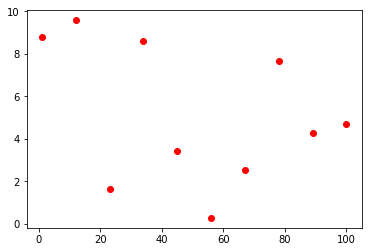

In [234]:
begin = 1.
end = 100.
nodes = 10
x = np.linspace(begin, end, nodes)
y = np.random.rand(len(x)) * 10
plt.plot(x, y, 'ro')

In [237]:
newton, _ = newtonInterpolation(x, y)
lagrange, _ = lagrangeInterpolation(x, y)
python, _ = polyfitInterpolation(x, y)

In [238]:
x2 = np.arange(begin - 0.1, end + 0.1, 0.02)

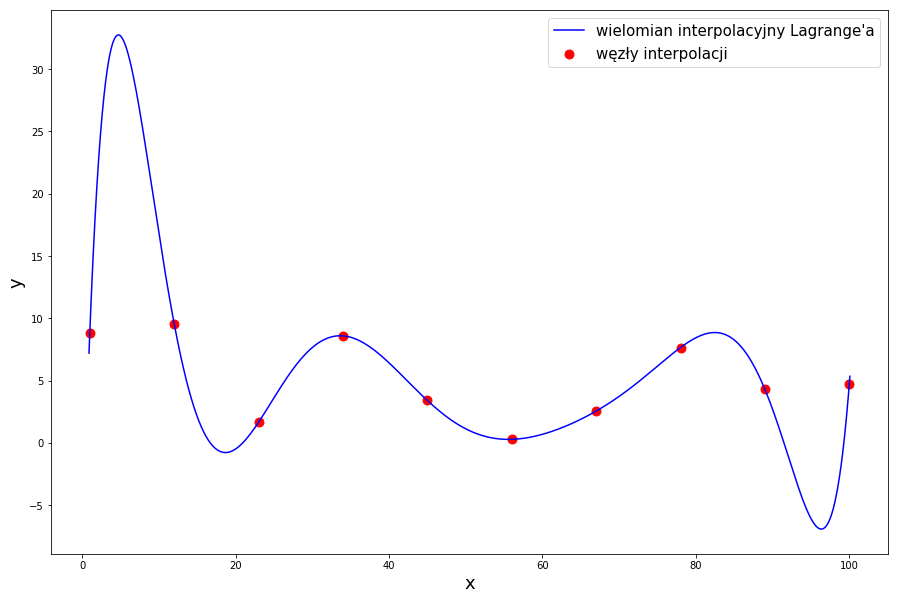

In [263]:
plt.figure(figsize=(15,10))
plt.scatter(x, y, s=80, c='r', label="węzły interpolacji")
plt.plot(x2, lagrange(x2), c='b', label="wielomian interpolacyjny Lagrange'a")
plt.legend(loc='upper right', prop={'size': 15})
plt.xlabel('x', size=18)
plt.ylabel('y', size=18)
#plt.xlim(90, 100)

plt.savefig('lagrange.pdf')

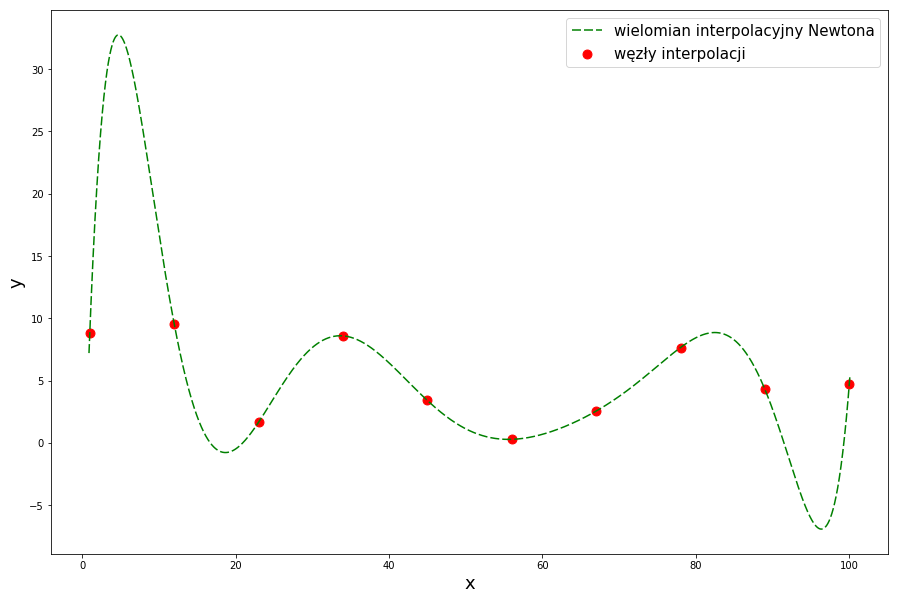

In [262]:
plt.figure(figsize=(15,10))
plt.scatter(x, y, s=80, c='r', label="węzły interpolacji")
plt.plot(x2, newton(x2), c='g', label="wielomian interpolacyjny Newtona", dashes=[6, 2])
plt.legend(loc='upper right', prop={'size': 15})
plt.xlabel('x', size=18)
plt.ylabel('y', size=18)
plt.savefig('newton.pdf')

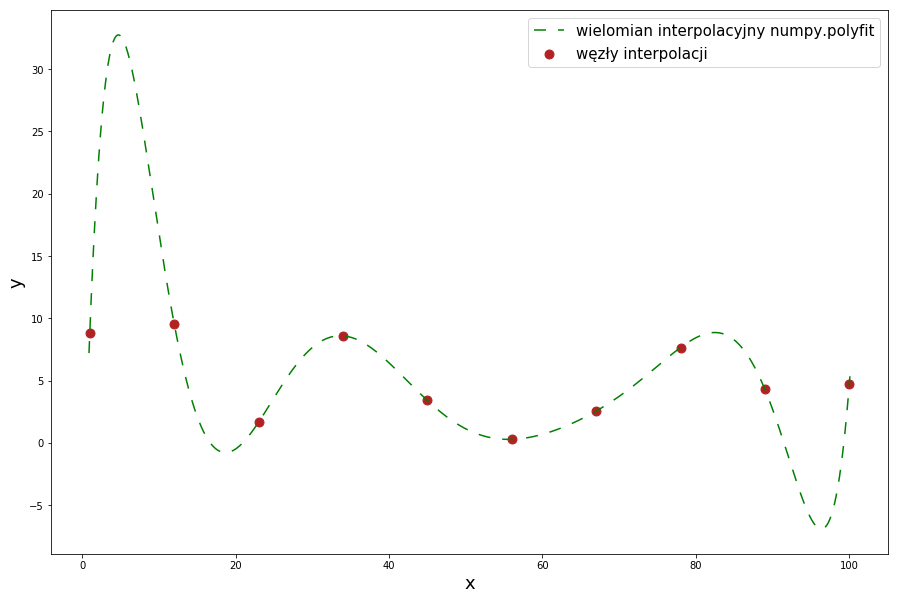

In [261]:
plt.figure(figsize=(15,10))
plt.scatter(x, y, s=80, c='firebrick', label="węzły interpolacji")
plt.plot(x2, python(x2), c='g', label="wielomian interpolacyjny numpy.polyfit", dashes=[8, 8])
plt.legend(loc='upper right', prop={'size': 15})
plt.xlabel('x', size=18)
plt.ylabel('y', size=18)
plt.savefig('polyfit.pdf')

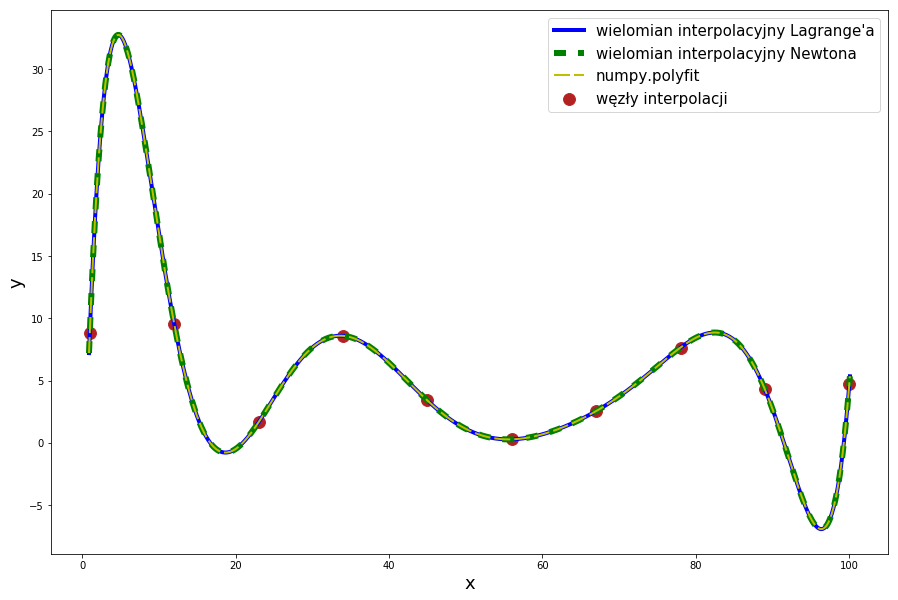

In [260]:
plt.figure(figsize=(15,10))
plt.scatter(x, y, s=140, c='firebrick', label="węzły interpolacji")
plt.plot(x2, lagrange(x2), c='b', label="wielomian interpolacyjny Lagrange'a", linewidth=4)
plt.plot(x2, newton(x2), c='g', label="wielomian interpolacyjny Newtona", dashes=[2, 2], linewidth=6)
plt.plot(x2, python(x2), c='y', label="numpy.polyfit", dashes=[8, 2], linewidth=2)
plt.legend(loc='upper right', prop={'size': 15})
plt.xlabel('x', size=18)
plt.ylabel('y', size=18)
plt.savefig('combined.pdf')

# Benchmark

In [65]:
begin = 1.
end = 100.
sizes = [i * 10 for i in range(1, 11)]
reps = 15

columns = ['interpolation', 'nodes', 'time']
df = pd.DataFrame(columns=columns)


for nodes in sizes:
    
    print(str(nodes) + ':', end='', flush=True)
    
    for i in range(reps):
        
        print('.', end='', flush=True)
        
        x = np.linspace(begin, end, nodes)
        y = np.random.rand(len(x))
        
        _, time1 = newtonInterpolation(x, y)
        _, time2 = lagrangeInterpolation(x, y)
        _, time3 = polyfitInterpolation(x, y)
        
        df = df.append({'interpolation': 'newton', 'nodes': nodes, 'time': time1}, ignore_index=True)
        df = df.append({'interpolation': 'lagrange', 'nodes': nodes, 'time': time2}, ignore_index=True)
        df = df.append({'interpolation': 'polyfit', 'nodes': nodes, 'time': time3}, ignore_index=True)
        
    print('')

10:...............
20:...............
30:...............
40:...............
50:...............
60:...............
70:...............
80:..

/home/mateusz/.local/lib/python3.6/site-packages/numpy/lib/polynomial.py:578: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


.............
90:..

/home/mateusz/.local/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


.............
100:...............


In [67]:
df.to_csv('times.csv')

In [181]:
results = df.groupby(['interpolation', 'nodes']).agg({'time': [np.mean, np.std]})
lagrange_df = results.loc[('lagrange'), ('time')]
newton_df = results.loc[('newton'), ('time')]
python_df = results.loc[('polyfit'), ('time')]

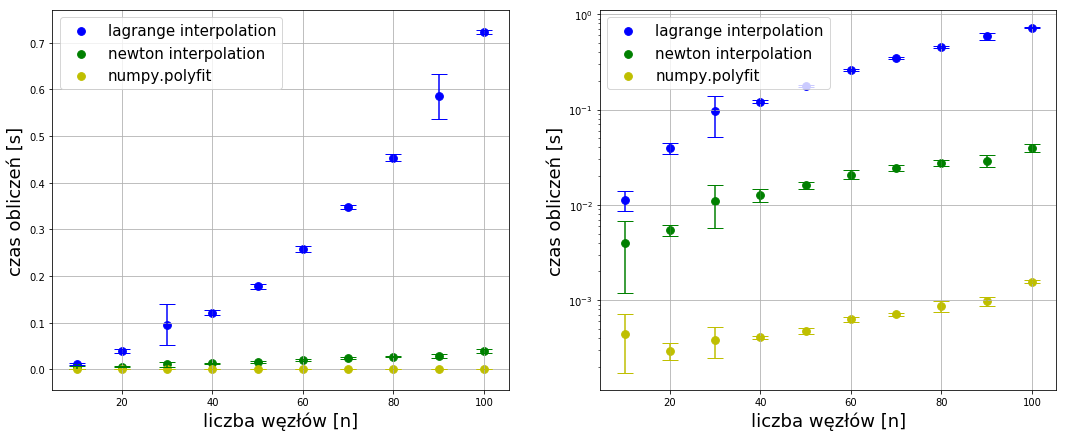

In [313]:
plt.figure(figsize=(18,7))

plt.subplot(1, 2, 1)
plt.scatter(lagrange_df.index, lagrange_df['mean'], s=60, c='b', label="lagrange interpolation")
plt.errorbar(lagrange_df.index, lagrange_df['mean'], yerr=lagrange_df['std'], fmt='none', c='b', capsize=8, label=None)

plt.scatter(newton_df.index, newton_df['mean'], s=60, c='g', label="newton interpolation")
plt.errorbar(newton_df.index, newton_df['mean'], yerr=newton_df['std'], fmt='none', c='g', capsize=8, label=None)

plt.scatter(python_df.index, python_df['mean'], s=60, c='y', label="numpy.polyfit")
plt.errorbar(python_df.index, python_df['mean'], yerr=python_df['std'], fmt='none', c='y', capsize=8, label=None)

plt.legend(loc='upper left', prop={'size': 15})
plt.xlabel('liczba węzłów [n]', size=18)
plt.ylabel('czas obliczeń [s]', size=18)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(lagrange_df.index, lagrange_df['mean'], s=60, c='b', label="lagrange interpolation")
plt.errorbar(lagrange_df.index, lagrange_df['mean'], yerr=lagrange_df['std'], fmt='none', c='b', capsize=8, label=None)

plt.scatter(newton_df.index, newton_df['mean'], s=60, c='g', label="newton interpolation")
plt.errorbar(newton_df.index, newton_df['mean'], yerr=newton_df['std'], fmt='none', c='g', capsize=8, label=None)

plt.scatter(python_df.index, python_df['mean'], s=60, c='y', label="numpy.polyfit")
plt.errorbar(python_df.index, python_df['mean'], yerr=python_df['std'], fmt='none', c='y', capsize=8, label=None)

plt.legend(loc='upper left', prop={'size': 15})
plt.xlabel('liczba węzłów [n]', size=18)
plt.ylabel('czas obliczeń [s]', size=18)
plt.grid(True)
plt.yscale('log')
plt.savefig('benchmark.pdf')

# Spline interpolation

In [246]:
linear_spline = sci.interp1d(x, y, kind='linear')
cubic_spline = sci.interp1d(x, y, kind='cubic')

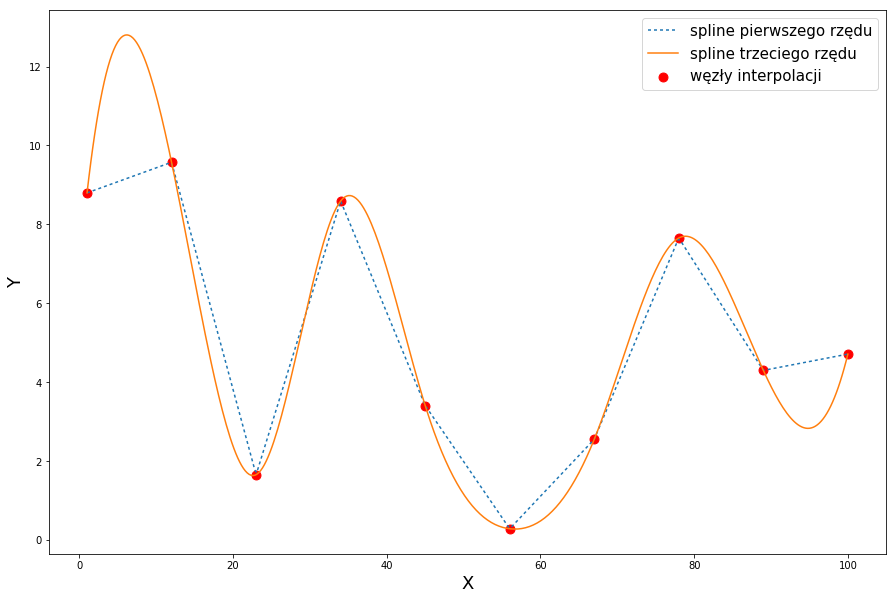

In [258]:
plt.figure(figsize=(15,10))

x3 = np.linspace(np.min(x), np.max(x), 400)

plt.scatter(x, y, c='r', s=80, label='węzły interpolacji')
plt.plot(x3, linear_spline(x3), label='spline pierwszego rzędu', dashes=[2, 2])
plt.plot(x3, cubic_spline(x3), label='spline trzeciego rzędu')

plt.legend(loc='upper right', prop={'size': 15})
plt.xlabel('X', size=18)
plt.ylabel('Y', size=18)
plt.savefig('splines.pdf')

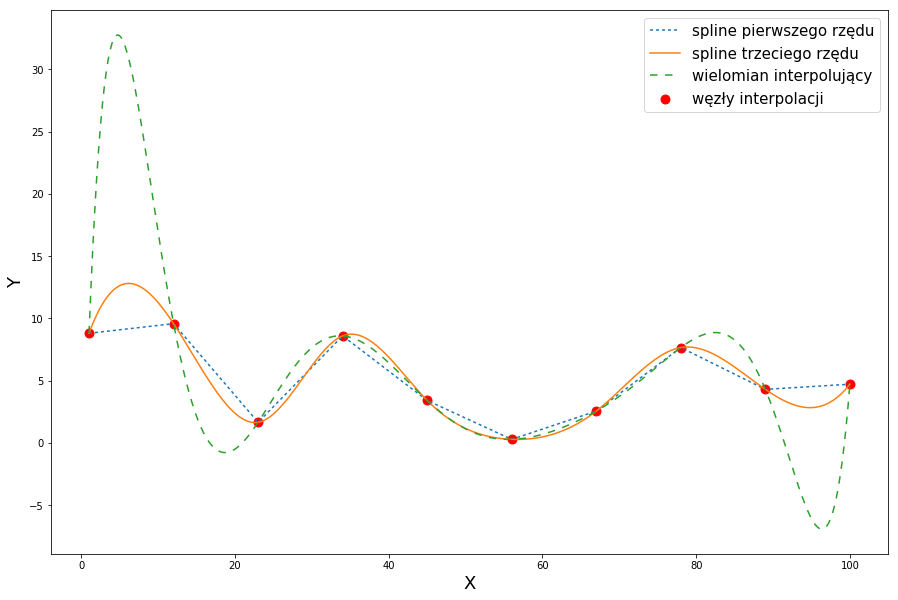

In [259]:
plt.figure(figsize=(15,10))

x3 = np.linspace(np.min(x), np.max(x), 400)

plt.scatter(x, y, c='r', s=80, label='węzły interpolacji')
plt.plot(x3, linear_spline(x3), label='spline pierwszego rzędu', dashes=[2, 2])
plt.plot(x3, cubic_spline(x3), label='spline trzeciego rzędu')
plt.plot(x3, python(x3), label='wielomian interpolujący', dashes=[5, 5])

plt.legend(loc='upper right', prop={'size': 15})
plt.xlabel('X', size=18)
plt.ylabel('Y', size=18)
plt.savefig('splines_comparison.pdf')

# Efekt Rungego

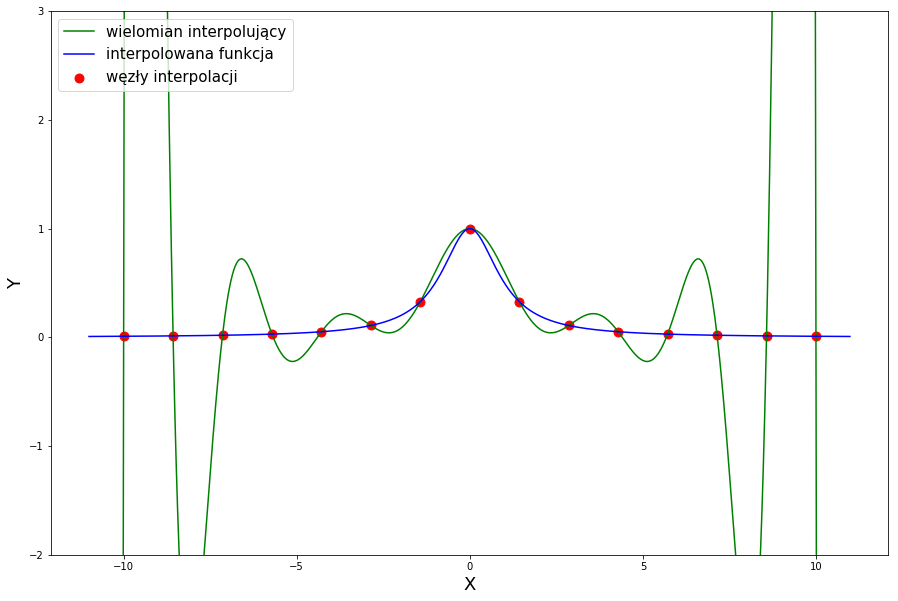

In [314]:
begin = -10.
end = 10.
nodes = 15

f = np.vectorize(lambda x : 1./(1. + x*x))
x = np.linspace(begin, end, nodes)
y = f(x)

poly = np.polyfit(x, y, len(x) - 1)

x2 = np.arange(-11., 11., 0.02)

plt.figure(figsize=(15,10))
plt.ylim(-2, 3)

plt.scatter(x, y, s=80, c='r', label='węzły interpolacji')
plt.plot(x2, np.polyval(poly, x2), c='g', label='wielomian interpolujący')
plt.plot(x2, f(x2), c='b', label='interpolowana funkcja')

plt.legend(loc='upper left', prop={'size': 15})
plt.xlabel('X', size=18)
plt.ylabel('Y', size=18)
plt.savefig('rungy15.pdf')

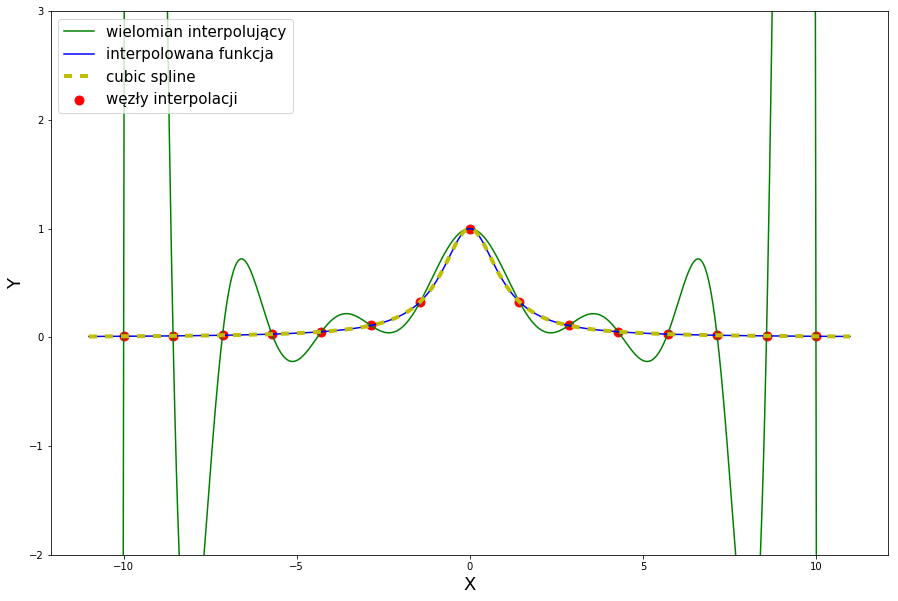

In [318]:
cubic_spline = sci.interp1d(x, y, kind='cubic')

plt.figure(figsize=(15,10))
plt.ylim(-2, 3)

plt.scatter(x, y, s=80, c='r', label='węzły interpolacji')
plt.plot(x2, np.polyval(poly, x2), c='g', label='wielomian interpolujący')
plt.plot(x2, f(x2), c='b', label='interpolowana funkcja')
plt.plot(x2, f(x2), c='y', label='cubic spline', linewidth=4, dashes=[2, 2])

plt.legend(loc='upper left', prop={'size': 15})
plt.xlabel('X', size=18)
plt.ylabel('Y', size=18)
plt.savefig('rungy_spline.pdf')

# Image resizing

In [276]:
source_im = Image.open("./baboon.png")
im = np.array(source_im)
xstart = 140
xend = 220
ystart = 40
yend = 120
im = im[ystart:yend, xstart:xend]
width = xend - xstart
height = yend - ystart

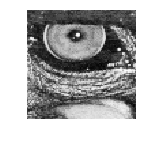

In [279]:
dpi = 96.
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(im, cmap="Greys_r")
plt.savefig('eye_small.pdf')

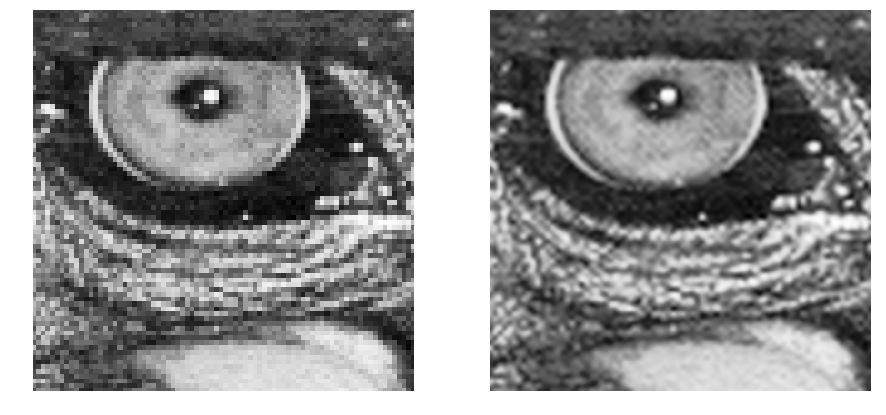

In [306]:
factor = 10
im_nearest = zoom(im, factor, order=0)
im_cubic = zoom(im, factor, order=3)

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(im_nearest, cmap="Greys_r")

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(im_cubic, cmap="Greys_r")

plt.savefig('eye_resized.pdf')

# Image rotating

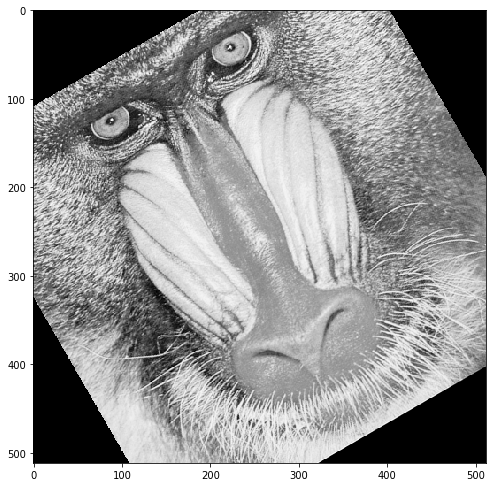

In [84]:
im = np.array(source_im)
angle = 30
im2 = rotate(im, angle, order=3, reshape=False)
plt.figure(figsize=((width / dpi) * factor, (height / dpi) * factor))
plt.imshow(im2, cmap="Greys_r")

# Frame interpolation

In [294]:
def blend(a, b, wa=0.5, wb=0.5):
    result = a * wa + b * wb
    return result

In [295]:
src = np.array(source_im)
angles = [i * 7.5 for i in range(49)]
tilts = [rotate(src, angle, order=3, reshape=False) for angle in angles]
blends = [blend(tilts[i], tilts[i+1]) for i in range(len(tilts) - 1)]
tilts = tilts[:-1]

In [296]:
blended_gif = [None] * (len(tilts) + len(blends))
blended_gif[::2] = tilts
blended_gif[1::2] = blends
blended_gif = list(map(Image.fromarray, blended_gif))

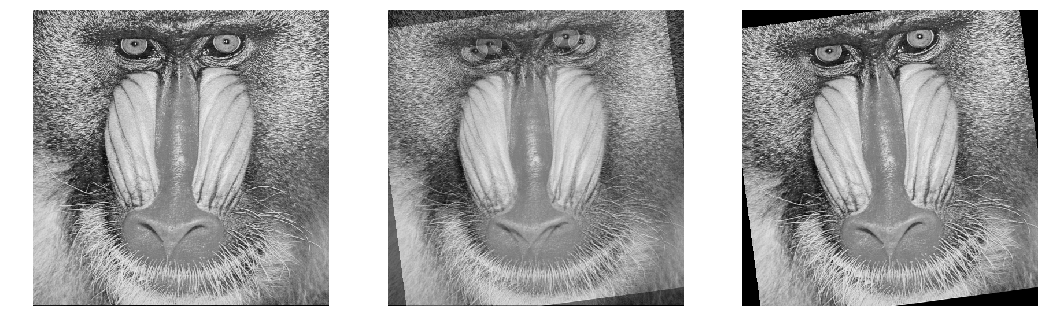

In [307]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(blended_gif[0], cmap="Greys_r")

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(blended_gif[1], cmap="Greys_r")

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(blended_gif[2], cmap="Greys_r")

plt.savefig('blend.pdf')

In [48]:
blended_gif[0].save("blended.gif", save_all=True, append_images=blended_gif[1:], loop=0, duration=150)

In [49]:
sampled_gif = [None] * len(tilts) * 2
sampled_gif[::2] = tilts
sampled_gif[1::2] = tilts
sampled_gif = list(map(Image.fromarray, sampled_gif))
sampled_gif[0].save("sampled.gif", save_all=True, append_images=sampled_gif[1:], loop=0, duration=150)

In [293]:
from IPython.display import HTML
HTML('<img src="./blended.gif">')

In [29]:
HTML('<img src="./sampled.gif">')